# Capstone Project - Predicting Energy Profile for Branded Food

## Section 1 - Introduction

<i> We see multiple branded food categories that have different energy and nutrient profiles - some of these branded food items also highlight multiple benefits (examples include low sugar, high fiber etc.) - the presence of so many data points can make it difficult for consumers to make an informed choice in a short time.<br>

<i>Machine learning concepts can be applied on a dataset that contains nutritional information and additional supporting factors for a large variety of branded food items available in the market today to understand which nutrients determine the overall calorie value for a particular food item and also predict the energy profile based on the nutrient composition.<br>

<i>The objectives of this project include:<br>
<i> a) Review the data provided in the US Department of Agriculture (USDA)<br>
<i> b) Prepare the data provided by USDA for use in this project<br>
<i> c) Review the data and make necessary transformations through Exploratory Data Analysis (EDA)<br>
<i> d) Build a machine learning model that shows the key nutrients influencing the overall energy / calorie value of foods<br>
<i> e) Evaluate alternate models and refine the chosen model to predict the energy value based on the nutrient profile<br>
<i> f) For a particular food category, predict the potential nutrient profile which would help a consumer make an informed purchase decision<br>

<i>This notebook currently focuses on the items (a) to (d) above.


## Section 2 - Brief Description about the Data Source

<i> The US Department of Agriculture (USDA) website hosts a section called ["FoodData Central" (FDC)](https://fdc.nal.usda.gov/), which is a comprehensive data system that provides detailed food and nutrient profiles, including nutrient values and metadata, for a wide array of foods. The FDC consolidates various data types, such as Foundation Foods, Experimental Foods, and the USDA Global Branded Food Products Database, to offer a broad perspective on the food supply.<br>

<i> For this project, the focus is on analyzing the branded food data provided by FDC. The data can be downloaded [here](https://fdc.nal.usda.gov/download-datasets) and has multiple CSV files.


## Section 3 - High Level Approach

<i> In order to build a baseline machine learning model, this document largely follows the CRISP-DM framework. The below phases would be executed:<br><br>
<i> <u>Phase 0: Data Preparation</u>: This phase involves reviewing the individual CSV files downloaded from USDA's FDC website and consolidating them into a single CSV file for this project<br><br>
<i><u>Phase 1: Data Understanding</u>: This phase imports the CSV file prepared above and does an initial exploration for understanding the columns and discovering patterns that need to be addressed (e.g. columns with unique / constant values, columns with large proportion of missing values, high level distribution properties of columns like mean and varance etc.)<br><br>
<i><u>Phase 2: Data Cleaning and Preparation</u>: This phase leverages multiple exploratory data analysis (EDA) techniques to make necessary changes to the dataset to make it more usable for building machine learning models. The focus areas here would include addressing missing values for critical columns, removing outliers if necessary, encoding critical categorical columns and finalizing the key columns needed for building the model. The end portion of this would involve correlating the different fields to find patterns / relationships.<br><br>
<i><u>Phase 3: Building a Baseline Model</u>: The prepared data would then be used for building an initial linear regression model, before which the data would be split into test and training datasets. The model performance would then be used as a baseline for the next iteration of this notebook.<br><br>

## Section 4: Data Preparation Phase [Phase 0]

<i> When we download the ZIP archive from the Branded Food row (CSV) in FDC's <a href="https://fdc.nal.usda.gov/download-datasets">Latest Downloads</a> page, there are multiple CSV files present. For this exercise, the below files are used:<br><br>
<i>a) branded_food.csv: This file has the data of all branded food items (unique FDC ID, company name, branded food name, branded food category, serving size and ingredient list. )<br><br>
<i>b) nutrient.csv: This file has a list of nutrients along with their unique nutrient IDs and unit name<br><br>
<i>c) food_nutrient.csv: This file shows the list of nutrients (indicated by nutrient IDs) for each branded food item (indicated by their FDC ID) and the amount of nutrients present in for each food ID - nutrient ID mapping<br><br>
<i>For this exercise, the target dataset should have columns that show the food category, food name, serving size, serving size unit, energy and individual columns for each nutrient. Since the above files are in different datasets, a Google Cloud BigQuery query (data_prep_bq.sql in the repo) was created that does the below:<br><br>
<i>1) Join the nutrient.csv and food_nutrient.csv file to show the nutrient name along with the nutrient ID for each food ID<br><br>
<i>2) Left join branded_food.csv data with the data from (1) to create a table that consolidates all the required data fields (food ID and name, food category, nutrient name, serving size and invidual nutrient quantities)<br><br>
<i>3) Pivot the table from (2) so that individual nutrients come up as columns instead of rows.<br>
The final table created is then queried and downloaded - the output of this query can be viewed in the file 'final_result_v2.csv' that will be used in the subsequent phases.<br>

## Section 5: Data Understanding [Phase 1]

<i> The objective of this phase is to load the data, review its schema and fields and identify the potential efforts needed to clean and prepare the data for model building

### a) Load Data and Review the Schema

<u>Step 1: Import Required Libraries<u>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error

<u>Step 2: Load the Data File & List Columns</u>

In [3]:
df_raw = pd.read_csv('final_result_v2.csv', low_memory=False)
pd.set_option('display.max_columns', None)
df_raw.head()

,fdc_id,brand_name,subbrand_name,food_name,branded_food_category,market_country,serving_size,serving_size_unit,Fatty_acids__total_saturated_G,Sugars__added_G,Fatty_acids__total_trans_G,Sodium__Na_MG,Thiamin_MG,Fiber__total_dietary_G,Vitamin_D__D2___D3___International_Units_IU,Protein_G,Pantothenic_acid_MG,Vitamin_C__total_ascorbic_acid_MG,Total_lipid__fat__G,Cholesterol_MG,Potassium__K_MG,Carbohydrate__by_difference_G,Total_Sugars_G,Calcium__Ca_MG,Iron__Fe_MG,Vitamin_B-6_MG,Energy_KCAL,Fatty_acids__total_polyunsaturated_G,Vitamin_A__IU_IU,Fatty_acids__total_monounsaturated_G,Folic_acid_UG,Vitamin_E__alpha-tocopherol__MG,Selenium__Se_UG,Manganese__Mn_MG,Niacin_MG,Phosphorus__P_MG,Zinc__Zn_MG,Riboflavin_MG,Folate__total_UG,Fiber__soluble_G,Vitamin_E_MG_ATE,Magnesium__Mg_MG,Vitamin_K__phylloquinone__UG,Vitamin_B-12_UG,Total_sugar_alcohols_G,Copper__Cu_MG,Carbohydrate__other_G,Fiber__insoluble_G,Iodine__I_UG,Water_G,Vitamin_E__label_entry_primarily__IU,Starch_G,Ash_G,Folate__DFE_UG,Molybdenum__Mo_UG,Chromium__Cr_UG,Biotin_UG,Energy_kJ,Chlorine__Cl_MG,Valine_G,Choline__total_MG,Vitamin_D__D2___D3__UG,Vitamin_A_UG,Vitamin_E_MG,Vitamin_A__RAE_UG,Caffeine_MG,Glycine_G,Lysine_G,Cystine_G,Isoleucine_G,Sugars__Total_G,Vitamin_D3__cholecalciferol__UG,Fluoride__F_UG,Alanine_G,Tryptophan_G,Methionine_G,Aspartic_acid_G,Leucine_G,Phenylalanine_G,Lactose_G,Glutamic_acid_G,Xylitol_G,Tyrosine_G,Histidine_G,Arginine_G,Serine_G,Threonine_G,Proline_G,Alcohol__ethyl_G
0,2318226,Brakebush®,NaN,"Chicken, FC Unbreaded Wing Jumbo Naked Wings N...",Meat/Poultry/Other Animals Prepared/Processed,United States,117.0,g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1325396,GREAT VALUE,NaN,"PEANUT SWEET & SALTY CHEWY GRANOLA BARS, PEANUT","Snack, Energy & Granola Bars",United States,35.0,g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1217881,MRS. PAUL'S,NaN,"CRUNCHY BREADED FISH FOR SANDWICHES FILLETS, C...",Frozen Fish & Seafood,United States,85.0,g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1249237,ORRINGTON FARMS,NaN,"ORIGINAL SEASONED BREADING FOR CHICKEN, ORIGINAL","Seasoning Mixes, Salts, Marinades & Tenderizers",United States,18.0,g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2308603,QUAKER,CHEWY,"CHOCOLATE CHIP GRANOLA BARS, CHOCOLATE CHIP","Snack, Energy & Granola Bars",United States,24.0,g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215740 entries, 0 to 215739
Data columns (total 89 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   fdc_id                                       215740 non-null  int64  
 1   brand_name                                   158192 non-null  object 
 2   subbrand_name                                13746 non-null   object 
 3   food_name                                    215740 non-null  object 
 4   branded_food_category                        214530 non-null  object 
 5   market_country                               215740 non-null  object 
 6   serving_size                                 215740 non-null  float64
 7   serving_size_unit                            214474 non-null  object 
 8   Fatty_acids__total_saturated_G               196307 non-null  float64
 9   Sugars__added_G                              87161 non-null

<i>The above output indicates that there are 89 columns and 215,740 columns. There are also multiple columns with a lot of missing values - however some critical columns like Energy, Carbohydrates, Protein, Fatty Acids, Food Category and Serving Size have a good chunk of values populated.<i>

In [4]:
df_raw.describe().map('{:,.2f}'.format)

,fdc_id,serving_size,Fatty_acids__total_saturated_G,Sugars__added_G,Fatty_acids__total_trans_G,Sodium__Na_MG,Thiamin_MG,Fiber__total_dietary_G,Vitamin_D__D2___D3___International_Units_IU,Protein_G,Pantothenic_acid_MG,Vitamin_C__total_ascorbic_acid_MG,Total_lipid__fat__G,Cholesterol_MG,Potassium__K_MG,Carbohydrate__by_difference_G,Total_Sugars_G,Calcium__Ca_MG,Iron__Fe_MG,Vitamin_B-6_MG,Energy_KCAL,Fatty_acids__total_polyunsaturated_G,Vitamin_A__IU_IU,Fatty_acids__total_monounsaturated_G,Folic_acid_UG,Vitamin_E__alpha-tocopherol__MG,Selenium__Se_UG,Manganese__Mn_MG,Niacin_MG,Phosphorus__P_MG,Zinc__Zn_MG,Riboflavin_MG,Folate__total_UG,Fiber__soluble_G,Vitamin_E_MG_ATE,Magnesium__Mg_MG,Vitamin_K__phylloquinone__UG,Vitamin_B-12_UG,Total_sugar_alcohols_G,Copper__Cu_MG,Carbohydrate__other_G,Fiber__insoluble_G,Iodine__I_UG,Water_G,Vitamin_E__label_entry_primarily__IU,Starch_G,Ash_G,Folate__DFE_UG,Molybdenum__Mo_UG,Chromium__Cr_UG,Biotin_UG,Energy_kJ,Chlorine__Cl_MG,Valine_G,Choline__total_MG,Vitamin_D__D2___D3__UG,Vitamin_A_UG,Vitamin_E_MG,Vitamin_A__RAE_UG,Caffeine_MG,Glycine_G,Lysine_G,Cystine_G,Isoleucine_G,Sugars__Total_G,Vitamin_D3__cholecalciferol__UG,Fluoride__F_UG,Alanine_G,Tryptophan_G,Methionine_G,Aspartic_acid_G,Leucine_G,Phenylalanine_G,Lactose_G,Glutamic_acid_G,Xylitol_G,Tyrosine_G,Histidine_G,Arginine_G,Serine_G,Threonine_G,Proline_G,Alcohol__ethyl_G
count,"215,740.00","215,740.00","196,307.00","87,161.00","194,369.00","202,747.00","39,506.00","195,694.00","78,437.00","203,354.00","8,158.00","99,803.00","202,152.00","193,468.00","125,507.00","202,706.00","202,216.00","192,494.00","191,148.00","26,971.00","200,438.00","48,390.00","94,771.00","48,445.00","18,116.00",418.00,"2,435.00","2,799.00","37,082.00","23,997.00","21,034.00","37,897.00","15,102.00","6,845.00",672.00,"16,464.00","1,207.00","20,690.00","7,240.00","5,391.00","3,663.00","8,554.00","1,285.00",865.00,873.00,12.00,868.00,470.00,137.00,72.00,302.00,1.00,49.00,5.00,164.00,"17,507.00","4,597.00",654.00,"1,352.00",26.00,5.00,5.00,5.00,1.00,75.00,11.00,13.00,5.00,5.00,5.00,5.00,5.00,5.00,8.00,5.00,2.00,4.00,5.00,5.00,5.00,5.00,5.00,1.00
mean,"1,639,340.07",73.78,3.79,15.61,0.02,"1,107.00",0.73,4.12,"1,541.49",9.15,3.03,6.56,10.15,24.75,358.86,45.99,18.23,126.26,4.66,1.10,302.30,2.30,"1,045.17",3.43,294.98,6.54,32.48,1.36,8.24,362.20,6.67,1.19,"110,119.52",3.10,10.82,88.82,24.44,"21,444.11",10.04,0.63,39.80,5.32,56.04,9.30,"14,104.65",43.33,2.49,242.81,26.39,72.79,300.12,517.00,226.08,0.44,665.49,"3,443.88",279.22,5.01,161.40,1.38,0.37,0.30,0.15,0.34,20.27,0.53,"23,076.92",0.41,0.13,0.17,0.64,0.75,0.50,0.37,2.73,3.00,0.35,0.25,0.54,0.42,0.32,0.94,7.50
std,"691,672.88",58.39,5.98,19.10,0.59,"37,472.37",3.26,5.46,"420,086.10",9.46,4.36,32.75,14.25,907.79,"6,963.73",43.50,20.35,"1,574.47",114.67,1.11,270.70,2.97,"91,695.55",4.91,"5,558.17",5.11,175.72,2.01,22.56,"8,842.99",5.76,102.74,"3,923,249.17",3.10,16.23,65.23,61.65,"1,170,379.57",10.55,0.95,18.55,4.29,39.65,10.85,"55,384.64",4.02,1.59,215.30,19.75,43.81,"1,926.89",nan,146.33,0.02,"1,063.16","385,752.96","9,633.78",6.65,99.50,2.58,0.01,0.01,0.01,nan,15.96,1.75,"56,330.07",0.02,0.00,0.01,0.01,0.04,0.02,1.05,0.17,1.41,0.00,0.00,0.01,0.01,0.00,0.07,nan
min,"344,620.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,1.50,0.00,38.50,0.00,12.00,0.00,0.00,0.00,517.00,0.00,0.41,0.00,0.00,0.00,0.00,0.00,0.00,0.35,0.29,0.13,0.34,0.00,0.00,0.00,0.37,0.13,0.15,0.64,0.68,0.46,0.00,2.41,2.00,0.35,0.24,0.54,0.40,0.31,0.82,7.50
25%,"1,139,496.75",35.00,0.00,3.80,0.00,67.00,0.00,0.70,0.00,4.17,0.82,0.00,1.86,0.00,107.00,22.33,5.00,31.00,0.40,0.53,179.00,0.00,0.00,0.00,61.00,1.00,4.00,0.00,3.85,113.00,3.21,0.25,85.00,2.00,4.00,53.00,1.70,1.43,0.00,0.27,25.00,2.00,30.00,3.00,0.00,38.50,1.60,95.00,12.00,54.75,10.00,517.00,146.00,0.44,57.00,0.00,0.00,1.99,79.00,0.00,0.38

In [6]:
# 3a) Review the number of Null values in each field
sourceData_nullCounts = df_raw.isnull().sum(axis=0)
sourceData_nullCount_pct = sourceData_nullCounts / len(df_raw)
pd.set_option('display.max_rows', None)
pd.DataFrame({'Null Count': sourceData_nullCounts,'Null Count %': sourceData_nullCount_pct}).sort_values('Null Count %',ascending=False)

,Null Count,Null Count %
Isoleucine_G,215739,0.999995
Alcohol__ethyl_G,215739,0.999995
Energy_kJ,215739,0.999995
Xylitol_G,215738,0.999991
Tyrosine_G,215736,0.999981
Glutamic_acid_G,215735,0.999977
Cystine_G,215735,0.999977
Arginine_G,215735,0.999977
Valine_G,215735,0.999977
Aspartic_acid_G,215735,0.999977


<i>From the above outputs, it shows that a lot of nutrient columns have a large number of missing values which would not be useful when building the model. Hence these columns can be dropped.<br>

<i> The below code removes those columns that have 80% or more records missing

In [7]:
df_modified = df_raw.dropna(axis=1,thresh=(1-0.8)*len(df_raw))
sourceData_nullCounts = df_modified.isnull().sum(axis=0)
sourceData_nullCount_pct = sourceData_nullCounts / len(df_modified)
pd.set_option('display.max_rows', None)
pd.DataFrame({'Null Count': sourceData_nullCounts,'Null Count %': sourceData_nullCount_pct}).sort_values('Null Count %',ascending=False)

,Null Count,Null Count %
Fatty_acids__total_polyunsaturated_G,167350,0.775702
Fatty_acids__total_monounsaturated_G,167295,0.775447
Vitamin_D__D2___D3___International_Units_IU,137303,0.636428
Sugars__added_G,128579,0.595991
Vitamin_A__IU_IU,120969,0.560717
Vitamin_C__total_ascorbic_acid_MG,115937,0.537392
Potassium__K_MG,90233,0.418249
brand_name,57548,0.266747
Iron__Fe_MG,24592,0.113989
Calcium__Ca_MG,23246,0.107750


<i> The below code checks for any uplicate rows - as the output indicates, there are no duplicates. Subsequently it is also verified that the column fdc_id has all unique values (215,740) and the column market_country has only 2 unique values - hence these 2 also need not be factored for model  building <br>

In [8]:
# 3b) Check if the dataset has any duplicate values
duplicate_rows = df_modified[df_modified.duplicated()]
print(duplicate_rows)

Empty DataFrame
Columns: [fdc_id, brand_name, food_name, branded_food_category, market_country, serving_size, serving_size_unit, Fatty_acids__total_saturated_G, Sugars__added_G, Fatty_acids__total_trans_G, Sodium__Na_MG, Fiber__total_dietary_G, Vitamin_D__D2___D3___International_Units_IU, Protein_G, Vitamin_C__total_ascorbic_acid_MG, Total_lipid__fat__G, Cholesterol_MG, Potassium__K_MG, Carbohydrate__by_difference_G, Total_Sugars_G, Calcium__Ca_MG, Iron__Fe_MG, Energy_KCAL, Fatty_acids__total_polyunsaturated_G, Vitamin_A__IU_IU, Fatty_acids__total_monounsaturated_G]
Index: []


In [9]:
#Count the number of unique values in fdc_id and market_country columns since they could potentially be unique identifiers
print(df_modified['fdc_id'].nunique())
print(df_modified['market_country'].nunique())

215740
2


## Section 6: Data Cleaning and Preparation [Phase 2]

<i>This phase includes all the steps for cleaning and preparing the data for model development. The branded food category and serving size unit columns will be reviewed first, after which the numerical columns can be analyzed<br>

### a) Analyze the Branded Food Category Column

<i><u>Step 1: Review the Branded Food Category Column </u></i>

<i> The branded food category column indicates the category a food item belongs to (e.g. Cereal, Breads etc.). If this column has to be used post encoding, the column should have as less unique values as possible.<br>

In [10]:
#Review the branded food category column
print(df_modified['branded_food_category'].value_counts().to_frame())

                                                    count
branded_food_category                                    
Snack, Energy & Granola Bars                        35941
Yogurt                                              32376
Breads & Buns                                       27584
Cereal                                              19162
Ice Cream & Frozen Yogurt                            9879
Processed Cereal Products                            8456
Chocolate                                            5591
Cookies & Biscuits                                   5496
Croissants, Sweet Rolls, Muffins & Other Pastries    4246
Candy                                                4195
Ketchup, Mustard, BBQ & Cheese Sauce                 4028
Bread & Muffin Mixes                                 3911
Popcorn, Peanuts, Seeds & Related Snacks             3457
Cake, Cookie & Cupcake Mixes                         3420
Frozen Appetizers & Hors D'oeuvres                   3266
Frozen Pancake

<i> From the above we can observe the below:<br>
<i> a) There seem to be a lot of categories that highly overlap (e.g. 'Baby/Infant  Foods/Beverages' and 'Baby/Infant – Foods/Beverages'). There is an oportunity to consolidate this as well.<br>
<i>b) There are a lot of categories with very few rows. Since there are 215K rows, we can probably remove those food categories that have less than 100 entries<br>

<i><u>Step 2: Rationalize the Column</u>


<i> The above list of unique branded food category values was reviewed separately during which revised category names were identified. The revised mapping can be viewed in the file 'Capstone - Food Category Mapping - Sheet1.csv'.<br><br>
<i> In this step, we will read this CSV file and update the existing food categories to their revised categories

In [10]:

df_revised_food_categories = pd.read_csv("Capstone - Food Category Mapping - Sheet1.csv")
df_revised_food_categories.head()

,branded_food_category,revised_food_category
0,Alcohol,Alcohol
1,Alcoholic Beverages,Alcoholic Beverages
2,All Noodles,All Noodles
3,Baby/Infant Foods/Beverages,Baby/Infant Foods/Beverages
4,Baby/Infant – Foods/Beverages,Baby/Infant Foods/Beverages


In [11]:
df_modified['branded_food_category']=df_modified['branded_food_category'].replace(df_revised_food_categories.set_index('branded_food_category')['revised_food_category'].to_dict())
print(df_modified['branded_food_category'].value_counts().to_frame())

                                                    count
branded_food_category                                    
Bread - Incl. Buns And Rolls                        37896
Snack, Energy & Granola Bars                        35941
Yogurt                                              35102
Cereal                                              19636
Ice Cream & Frozen Yogurt                            9888
Processed Cereal Products                            8456
Cookies & Biscuits                                   5665
Chocolate                                            5591
Candy                                                4195
Ketchup, Mustard, BBQ & Cheese Sauce                 4028
Popcorn, Peanuts, Seeds & Related Snacks             3457
Baking/Cooking Mixes (Shelf Stable)                  3452
Frozen Appetizers & Hors D'oeuvres                   3266
Frozen Pancakes, Waffles, French Toast & Crepes      3137
Meat/Poultry/Other Animals                           2554
Chips, Pretzel

/var/tmp/ipykernel_4144/3896262617.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_modified['branded_food_category']=df_modified['branded_food_category'].replace(df_revised_food_categories.set_index('branded_food_category')['revised_food_category'].to_dict())


<i><u>Step 3: Remove Rows where the Food Category Frequency is Less than 100

<i> Even after the above cleanup, there are multiple food categories which have very low values. For the purpose of this model building, category values with less than 100 entries will be removed.</i>

In [12]:
food_category_list = df_modified['branded_food_category'].value_counts()
list_to_remove = food_category_list[food_category_list < 100].index.tolist()
print(list_to_remove)

['Breakfast Sandwiches, Biscuits & Meals', 'Other Cooking Sauces', 'Oriental, Mexican & Ethnic Sauces', 'Herbs & Spices', 'Prepared Wraps and Burittos', 'Powdered Drinks', 'Non Alcoholic Beverages', 'Vegetables – Prepared/Processed', 'Bacon, Sausages & Ribs', 'Canned Soup', 'Vegetable and Lentil Mixes', 'Canned & Bottled Beans', 'Soda', 'Canned Meat', 'Poultry, Chicken & Turkey', 'Grains/Flour', 'Entrees, Sides & Small Meals', 'Vegetable & Cooking Oils', 'Prepared Pasta & Pizza Sauces', 'Flavored Rice Dishes', 'Sauces/Spreads/Dips/Condiments', 'Sausages, Hotdogs & Brats', 'Frozen Bacon, Sausages & Ribs', 'Other Frozen Meats', 'Salads', 'Canned Condensed Soup', 'Ready-Made Combination Meals', 'Canned Vegetables', 'Dinnex Mixes', 'Green Supplements', 'Meat/Poultry/Other Animals Sausages  Prepared/Processed', 'Other Condiments', 'Snack Bars', 'Chili & Stew', 'Tea Bags', 'Prepared/Preserved Foods Variety Packs', 'Alcohol', 'Plant Based Water', 'Specialty Formula Supplements', 'Canned Seafo

In [18]:
df_modified = df_modified[~df_modified['branded_food_category'].isin(list_to_remove)]
count_nas = df_modified['branded_food_category'].isna().sum()
print (f"Number of rows with no value for branded food category is: " + str(count_nas))
df_modified = df_modified.dropna(subset=['branded_food_category'])
print(df_modified['branded_food_category'].value_counts().to_frame())

Number of rows with no value for branded food category is: 0
                                                 count
branded_food_category                                 
Bread - Incl. Buns And Rolls                     37896
Snack, Energy & Granola Bars                     35941
Yogurt                                           35102
Cereal                                           19636
Ice Cream & Frozen Yogurt                         9888
Processed Cereal Products                         8456
Cookies & Biscuits                                5665
Chocolate                                         5591
Candy                                             4195
Ketchup, Mustard, BBQ & Cheese Sauce              4028
Popcorn, Peanuts, Seeds & Related Snacks          3457
Baking/Cooking Mixes (Shelf Stable)               3452
Frozen Appetizers & Hors D'oeuvres                3266
Frozen Pancakes, Waffles, French Toast & Crepes   3137
Meat/Poultry/Other Animals                        2554
Chip

<i>The above dataset can now be used for analyzing the next column - serving size unit.

### b) Review and Optimize the Serving Size Unit Column

<i> <u>Step 1: Consolidate the Different Serving Size Units in the Dataset:</u><br>
<i> The serving size unit column may have the same unit reflected as multiple values - hence it would be essential to clean this.

In [19]:
print(df_modified['serving_size_unit'].unique())
print(df_modified['serving_size_unit'].value_counts().to_frame())

['g' 'ml' 'IU' 'GRM' nan 'MG' 'MLT' 'MC' 'GM']
                    count
serving_size_unit        
g                  178998
GRM                 25434
ml                   4367
MG                   1327
IU                    632
MLT                   469
GM                     32
MC                      6


<i> The above output shows that the unit 'grams' is shown in multiple ways ('GRM', 'GM' and 'g'). Similarly milliliters is shown as multiple values ('ml', 'MLT'). Hence the below code snippet cleans this up to use only 'g' and 'ml' respectively. There are also 6 rows with the value 'MC' - these can be removed. There are also rows with serving size unit as 'NA' - this will be analyzed in the next step.<br><br>
<i> Consolidating the different serving size units below based on the above analysis. 

In [21]:
#clean the serving size unit column
df_modified.loc[df_modified['serving_size_unit']=='GRM','serving_size_unit'] = 'g'
df_modified.loc[df_modified['serving_size_unit']=='GM','serving_size_unit'] = 'g'
df_modified.loc[df_modified['serving_size_unit']=='MLT','serving_size_unit'] = 'ml'
print(df_modified['serving_size_unit'].unique())

['g' 'ml' 'IU' nan 'MG' 'MC']


<i>Since there are only 6 rows with serving size unit as 'MC', they can be removed.

In [22]:
#Delete rows with the serving size unit as 'MC'
df_modified = df_modified[df_modified['serving_size_unit'] != 'MC']
print(df_modified['serving_size_unit'].unique())

['g' 'ml' 'IU' nan 'MG']


<i><u>Step 2: Clean Up NA values</u><br>

<i> The below table shows the number of rows with serving sizes marked as NAs, grouped by the branded food category<br>

In [23]:
df_modified[df_modified['serving_size_unit'].isna()]['branded_food_category'].value_counts().to_frame()

,count
branded_food_category,
Yogurt,594
Bread - Incl. Buns And Rolls,171
"Snack, Energy & Granola Bars",116
Cereal,67
Cookies & Biscuits,33
Ice Cream & Frozen Yogurt,26
Frozen Dinners & Entrees,22
Frozen Appetizers & Hors D'oeuvres,17
"Ketchup, Mustard, BBQ & Cheese Sauce",15


<i> The above output shows that "Yogurt" has the maximum number of NA entries in the serving_size_unit column, followed by "Bread - Incl. Buns And Rolls" and "Snack, Energy & Granola Bars". A reasonable option here would be to replace them with the most frequent value within the category 

In [25]:
get_mode = lambda x: x.mode().iat[0]
df_modified['serving_size_unit'] = df_modified['serving_size_unit'].fillna(df_modified.groupby('branded_food_category')['Energy_KCAL'].transform(get_mode))
print("Remaining number of rows with missing serving size unit values: " + str(df_modified[df_modified['serving_size_unit'].isna()]['branded_food_category'].sum()))

Remaining number of rows with missing serving size unit values: 0


<i> Now that the branded food category and serving size unit columns have been analyzed and missing values have been updated, the numerical value columns need to be reviewed </i>

### c) Analyzing Key Numerical Columns

<i><u>Step 1: Revisit the Frequency of Missing Values

In [27]:
df_for_correlation = df_modified.copy()
df_for_correlation = df_for_correlation.drop(['fdc_id','market_country','brand_name','food_name'],axis=1)
sourceData_nullCounts = df_for_correlation.isnull().sum(axis=0)
sourceData_nullCount_pct = sourceData_nullCounts / len(df_for_correlation)
pd.set_option('display.max_rows', None)
pd.DataFrame({'Null Count': sourceData_nullCounts,'Null Count %': sourceData_nullCount_pct}).sort_values('Null Count %',ascending=True)

,Null Count,Null Count %
branded_food_category,0,0.000000
serving_size,0,0.000000
serving_size_unit,0,0.000000
Protein_G,12309,0.057920
Sodium__Na_MG,12688,0.059703
Carbohydrate__by_difference_G,12739,0.059943
Total_Sugars_G,13342,0.062781
Total_lipid__fat__G,13500,0.063524
Energy_KCAL,14029,0.066013
Fatty_acids__total_saturated_G,19102,0.089884


<i> Since there are still columns with a significant percentage of missing values, we could ignore them from the model building exercise. Looking at the above output, all columns after "Iron__Fe_MG" have 40%+ values mising - hence we can ignore these columns.

<i><u>Step 2: Review the Distribution of Numerical Columns

In [28]:
#Splitting the numerical columns into 2 lists to break down the computing power needed to do EDA
numerical_columns_1 = ["Protein_G", "Sodium__Na_MG", "Carbohydrate__by_difference_G", "Total_Sugars_G",
                     "Total_lipid__fat__G", "Energy_KCAL", "Fatty_acids__total_saturated_G"]
numerical_columns_2 = ["Fiber__total_dietary_G", "Fatty_acids__total_trans_G", "Cholesterol_MG", 
                     "Calcium__Ca_MG", "Iron__Fe_MG"]
#drop other columns since they have a large volume of NAN values
df_for_correlation = df_for_correlation.drop(columns = ['Potassium__K_MG','Vitamin_C__total_ascorbic_acid_MG','Vitamin_A__IU_IU','Sugars__added_G','Vitamin_D__D2___D3___International_Units_IU','Fatty_acids__total_monounsaturated_G','Fatty_acids__total_polyunsaturated_G'])

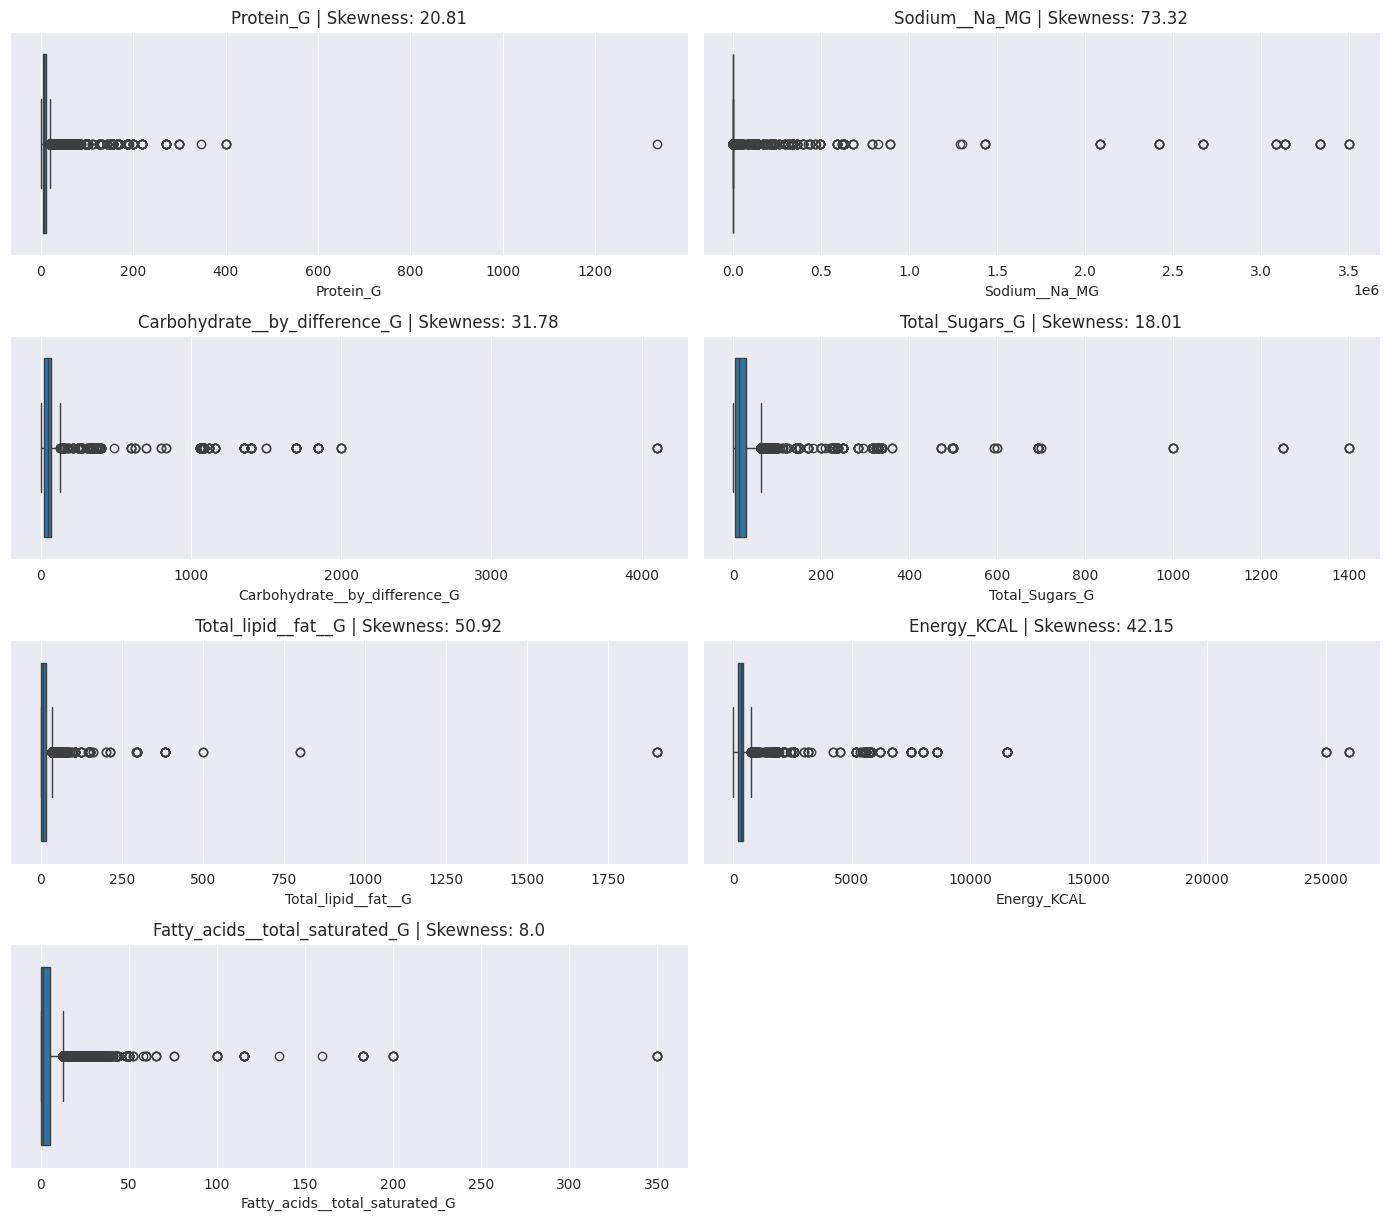

In [29]:
#Creating box plots for numerical column 1
sns.set_style("darkgrid")
numerical_columns = numerical_columns_1
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.boxplot(x=df_for_correlation[feature])
    plt.title(f"{feature} | Skewness: {round(df_for_correlation[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

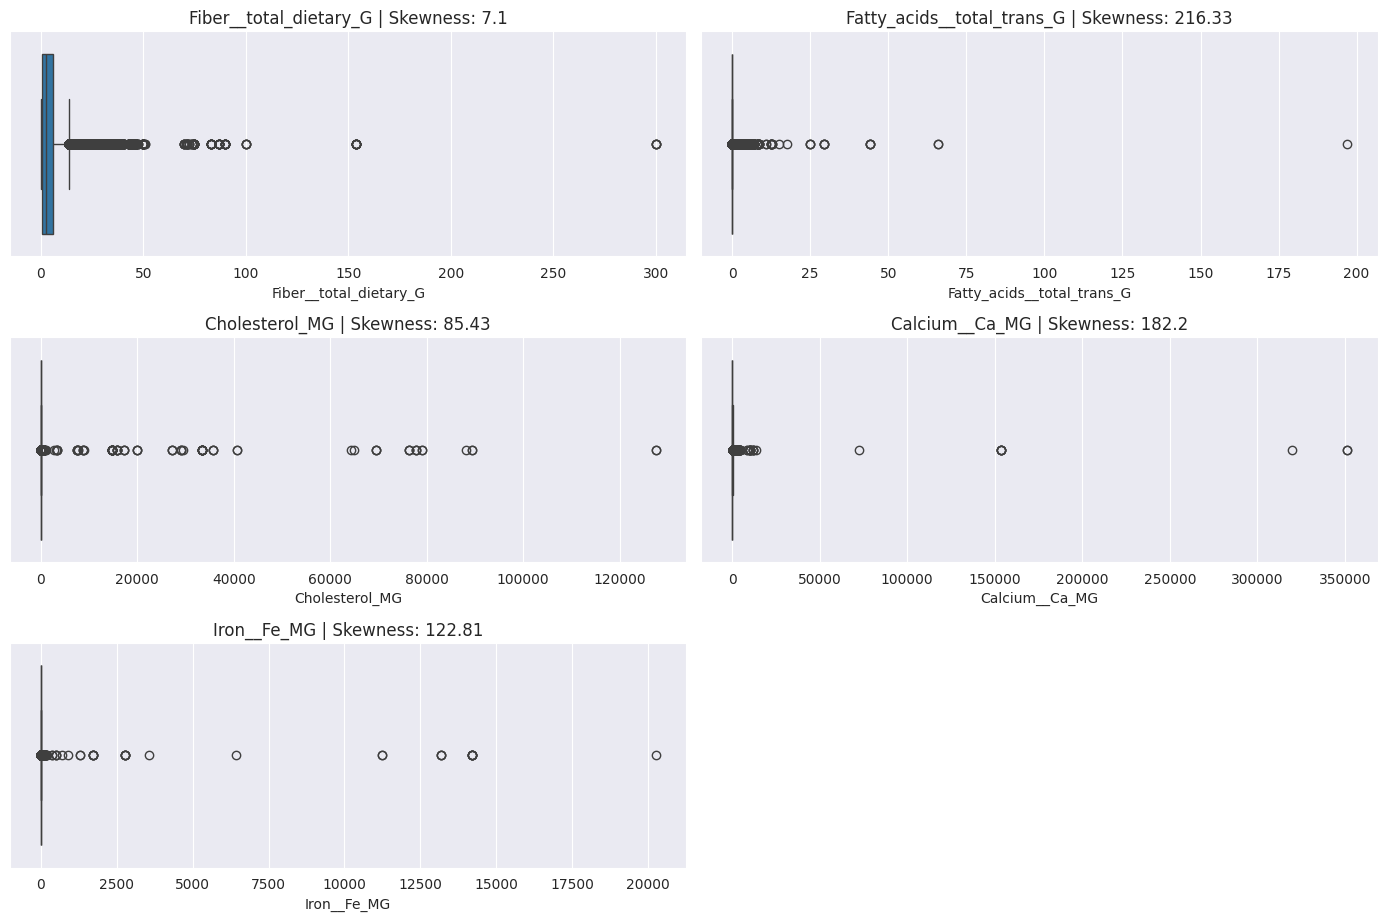

In [30]:
#Creating box plots for numerical column 2
sns.set_style("darkgrid")
numerical_columns = numerical_columns_2
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.boxplot(x=df_for_correlation[feature])
    plt.title(f"{feature} | Skewness: {round(df_for_correlation[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

<i>The above box plots indicate that almost all numerical columns are heavily skewed to the right, which indicates the potential to remove outliers from these columns. Creating histograms for these numerical columns to confim this understanding<br>

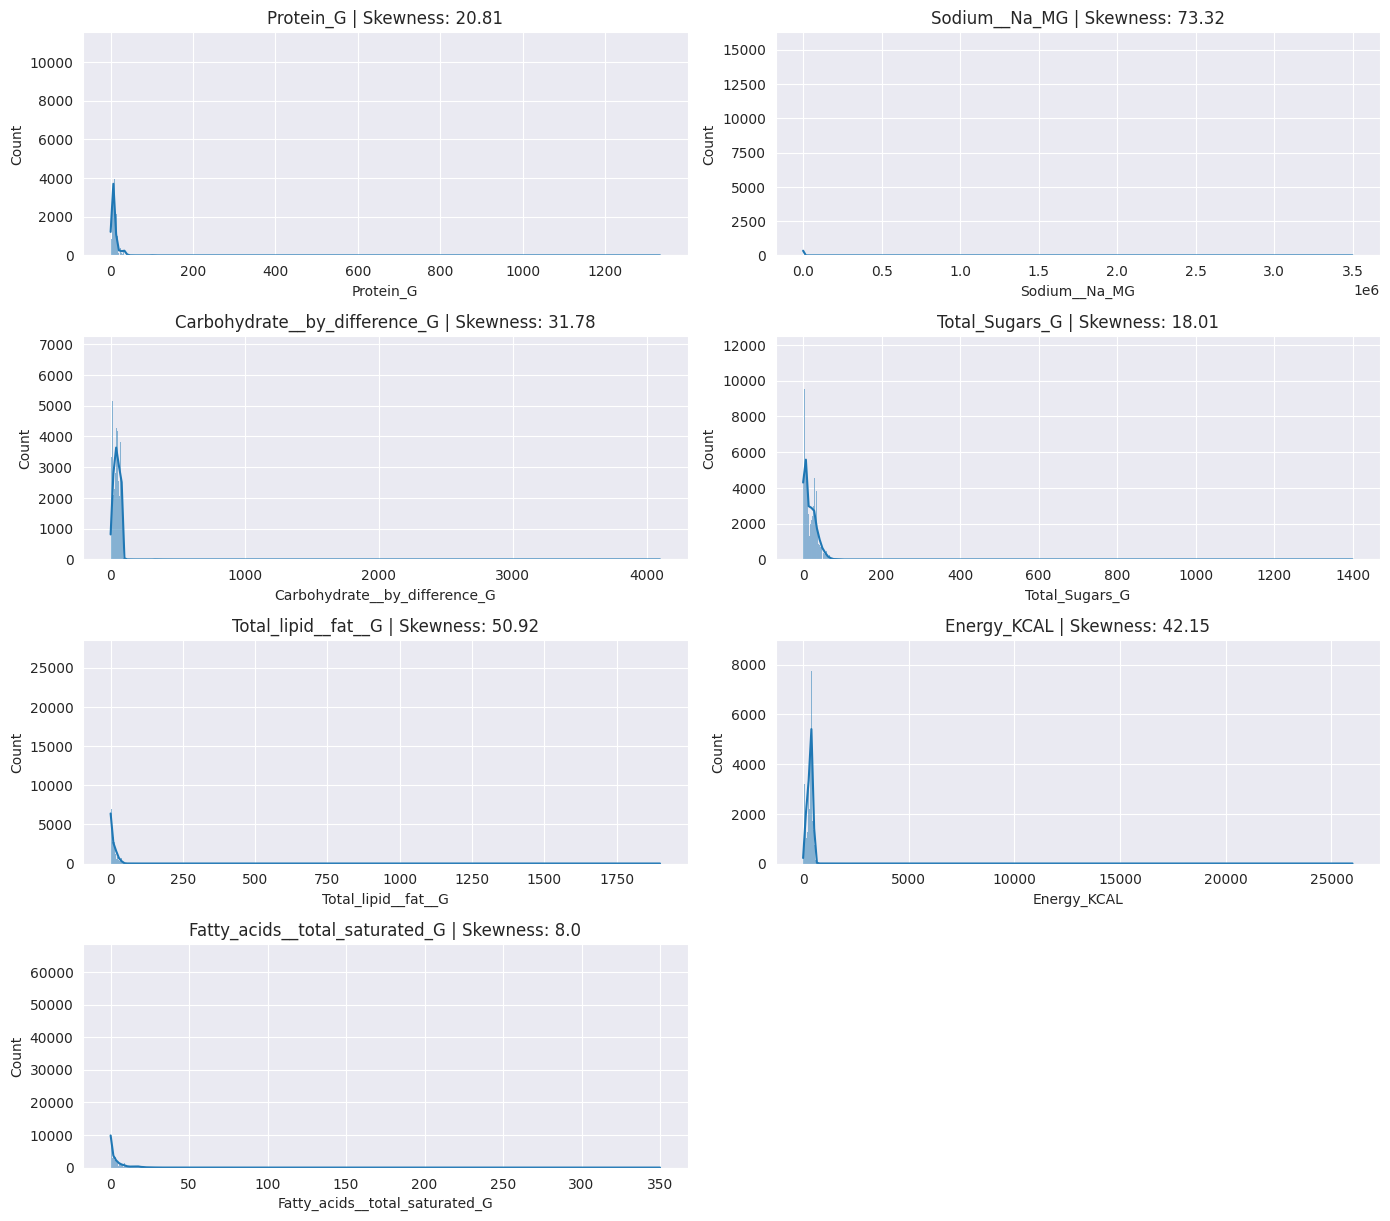

In [31]:
#Histogram plots for numerical column 1
sns.set_style("darkgrid")
numerical_columns = numerical_columns_1
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(df_for_correlation[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df_for_correlation[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

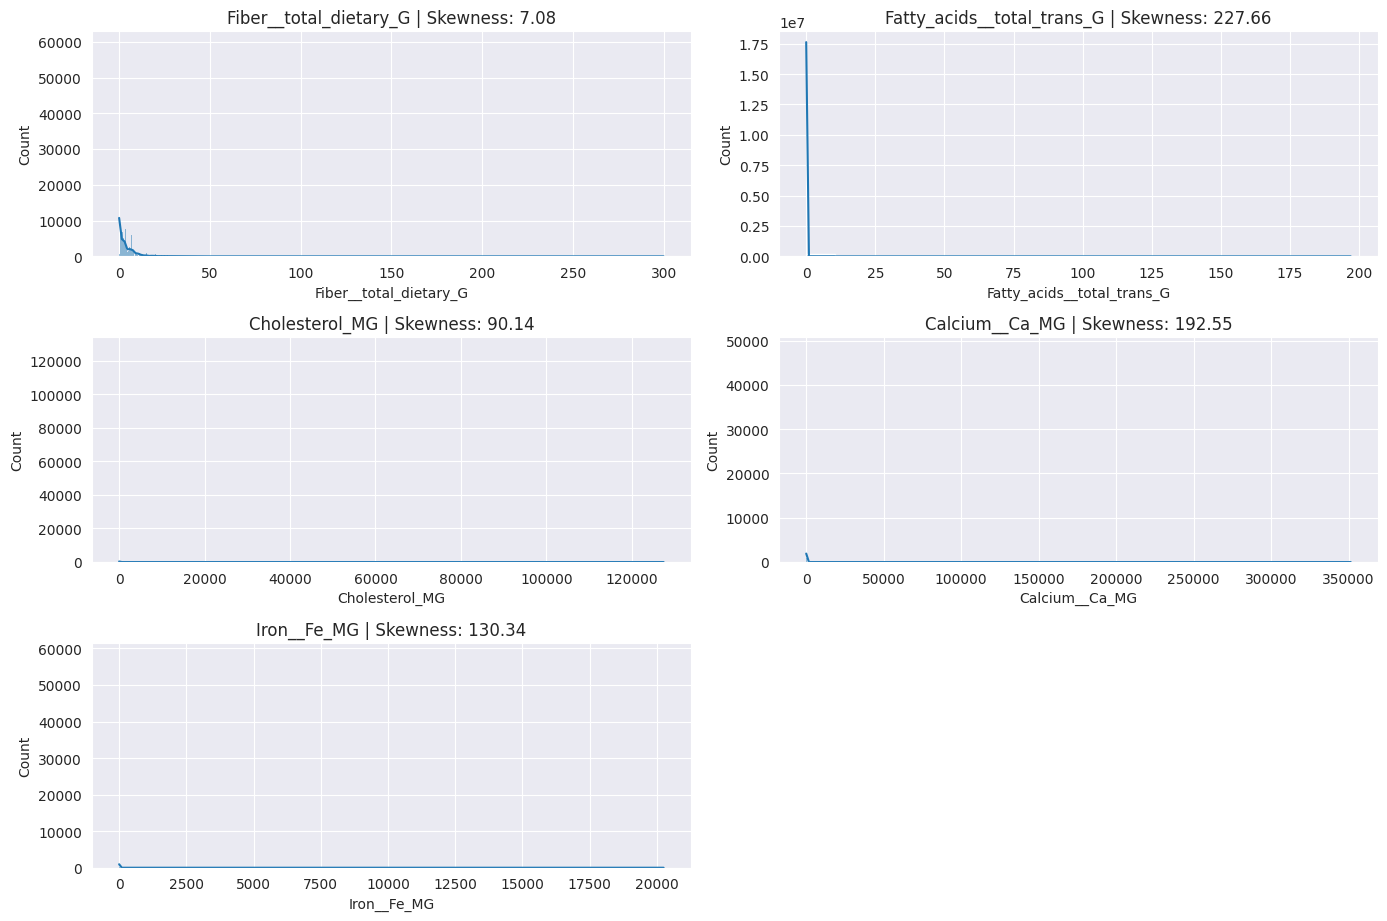

In [33]:
#Histogram plots for numerical column 2
sns.set_style("darkgrid")
numerical_columns = numerical_columns_2
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(df_for_correlation[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df_for_correlation[feature].skew(), 2)}")
plt.tight_layout()
plt.show()

<i><u>Step 3: Replace Missing Values in the Numerical Columns

<i> To replace the missing values, the strategy considered is to find the most frequent value for each combination of food category and serving size unit. This helps us have a more accurate replacement of missing values.<br><br>
For example, if a row that belongs to the Yogurt category has a missing energy value, then the most probable energy value would be the most frequent energy value observed across all Yogurts for the same serving size. If we only look at the food category, then there is a chance the most frequent value may belong to some other serving size unit which may lead to incorrect updates. And if we don't take the food category, then the energy value could be taken across other food categories which could introduce greater inaccuracies (e.g. Yogurt getting the energy value of Bread)

In [34]:

#Replace missing values for numerical columns with mode, grouping by food cateogry and serving size unit
get_mode = lambda x: x.mode()[0] if not x.mode().empty else np.nan
for col in numerical_columns_1:
    print("Column Name: " + col)
    print ("Number of NaNs before replacement: " + str(df_for_correlation[col].isna().sum()))
    df_for_correlation[col] = df_for_correlation[col].fillna(df_for_correlation.groupby(['branded_food_category','serving_size_unit'])[col].transform(get_mode))
    print ("Number of NaNs after replacement: " + str(df_for_correlation[col].isna().sum()))
    print("------------------------------------------------------------------------------")
for col in numerical_columns_2:
    print("Column Name: " + col)
    print ("Number of NaNs before replacement: " + str(df_for_correlation[col].isna().sum()))
    df_for_correlation[col] = df_for_correlation[col].fillna(df_for_correlation.groupby(['branded_food_category','serving_size_unit'])[col].transform(get_mode))
    print ("Number of NaNs after replacement: " + str(df_for_correlation[col].isna().sum()))
    print("------------------------------------------------------------------------------")

print(df_for_correlation.isna().sum())

Column Name: Protein_G
Number of NaNs before replacement: 3
Number of NaNs after replacement: 3
------------------------------------------------------------------------------
Column Name: Sodium__Na_MG
Number of NaNs before replacement: 3
Number of NaNs after replacement: 3
------------------------------------------------------------------------------
Column Name: Carbohydrate__by_difference_G
Number of NaNs before replacement: 3
Number of NaNs after replacement: 3
------------------------------------------------------------------------------
Column Name: Total_Sugars_G
Number of NaNs before replacement: 3
Number of NaNs after replacement: 3
------------------------------------------------------------------------------
Column Name: Total_lipid__fat__G
Number of NaNs before replacement: 3
Number of NaNs after replacement: 3
------------------------------------------------------------------------------
Column Name: Energy_KCAL
Number of NaNs before replacement: 3
Number of NaNs after rep

<i><u>Step 4: Drop Outliers where Applicable

<i> Now that the numerical columns do not have many missing values, the next step is to drop outliers where possible to make the dataset more suitable for model building.<br><br>
<i>For this, the z-score method will be used where z-scores not falling between -3 and +3 will be dropped from the dataset. 

In [35]:
#Dropping outliers
numerical_columns = numerical_columns_1
#Calculate the z-score for Price and add it as a column
df_correlations_without_outliers = df_for_correlation.copy()
for col in numerical_columns:
    z_col = "z_" + col
    df_correlations_without_outliers[z_col] = (df_correlations_without_outliers[col] - df_correlations_without_outliers[col].mean())/(df_correlations_without_outliers[col].std())
#Retain only those values that has an absolute z-score value of 3 or less
    rows_dropped = len(df_correlations_without_outliers[df_correlations_without_outliers[z_col].abs() > 3])
    print (f"{rows_dropped:d} rows will be dropped when removing outliers in column {col}")
    df_correlations_without_outliers = df_correlations_without_outliers[df_correlations_without_outliers[z_col].abs() <= 3].drop(z_col,axis=1)
    print("Number of rows after remaining outliers in column " + col + ": " + str(len(df_correlations_without_outliers)))
    print("---------------------------------------")

numerical_columns = numerical_columns_2
for col in numerical_columns:
    z_col = "z_" + col
    df_correlations_without_outliers[z_col] = (df_correlations_without_outliers[col] - df_correlations_without_outliers[col].mean())/(df_correlations_without_outliers[col].std())
#Retain only those values that has an absolute z-score value of 3 or less
    rows_dropped = len(df_correlations_without_outliers[df_correlations_without_outliers[z_col].abs() > 3])
    print (f"{rows_dropped:d} rows will be dropped when removing outliers in column {col}")
    df_correlations_without_outliers = df_correlations_without_outliers[df_correlations_without_outliers[z_col].abs() <= 3].drop(z_col,axis=1)
    print("Number of rows after remaining outliers in column " + col + ": " + str(len(df_correlations_without_outliers)))
    print("---------------------------------------")

df_correlations_without_outliers.isna().any(axis=1).sum()

1264 rows will be dropped when removing outliers in column Protein_G
Number of rows after remaining outliers in column Protein_G: 211251
---------------------------------------
194 rows will be dropped when removing outliers in column Sodium__Na_MG
Number of rows after remaining outliers in column Sodium__Na_MG: 211057
---------------------------------------
67 rows will be dropped when removing outliers in column Carbohydrate__by_difference_G
Number of rows after remaining outliers in column Carbohydrate__by_difference_G: 210990
---------------------------------------
1661 rows will be dropped when removing outliers in column Total_Sugars_G
Number of rows after remaining outliers in column Total_Sugars_G: 209329
---------------------------------------
1662 rows will be dropped when removing outliers in column Total_lipid__fat__G
Number of rows after remaining outliers in column Total_lipid__fat__G: 207667
---------------------------------------
17 rows will be dropped when removing ou

np.int64(0)

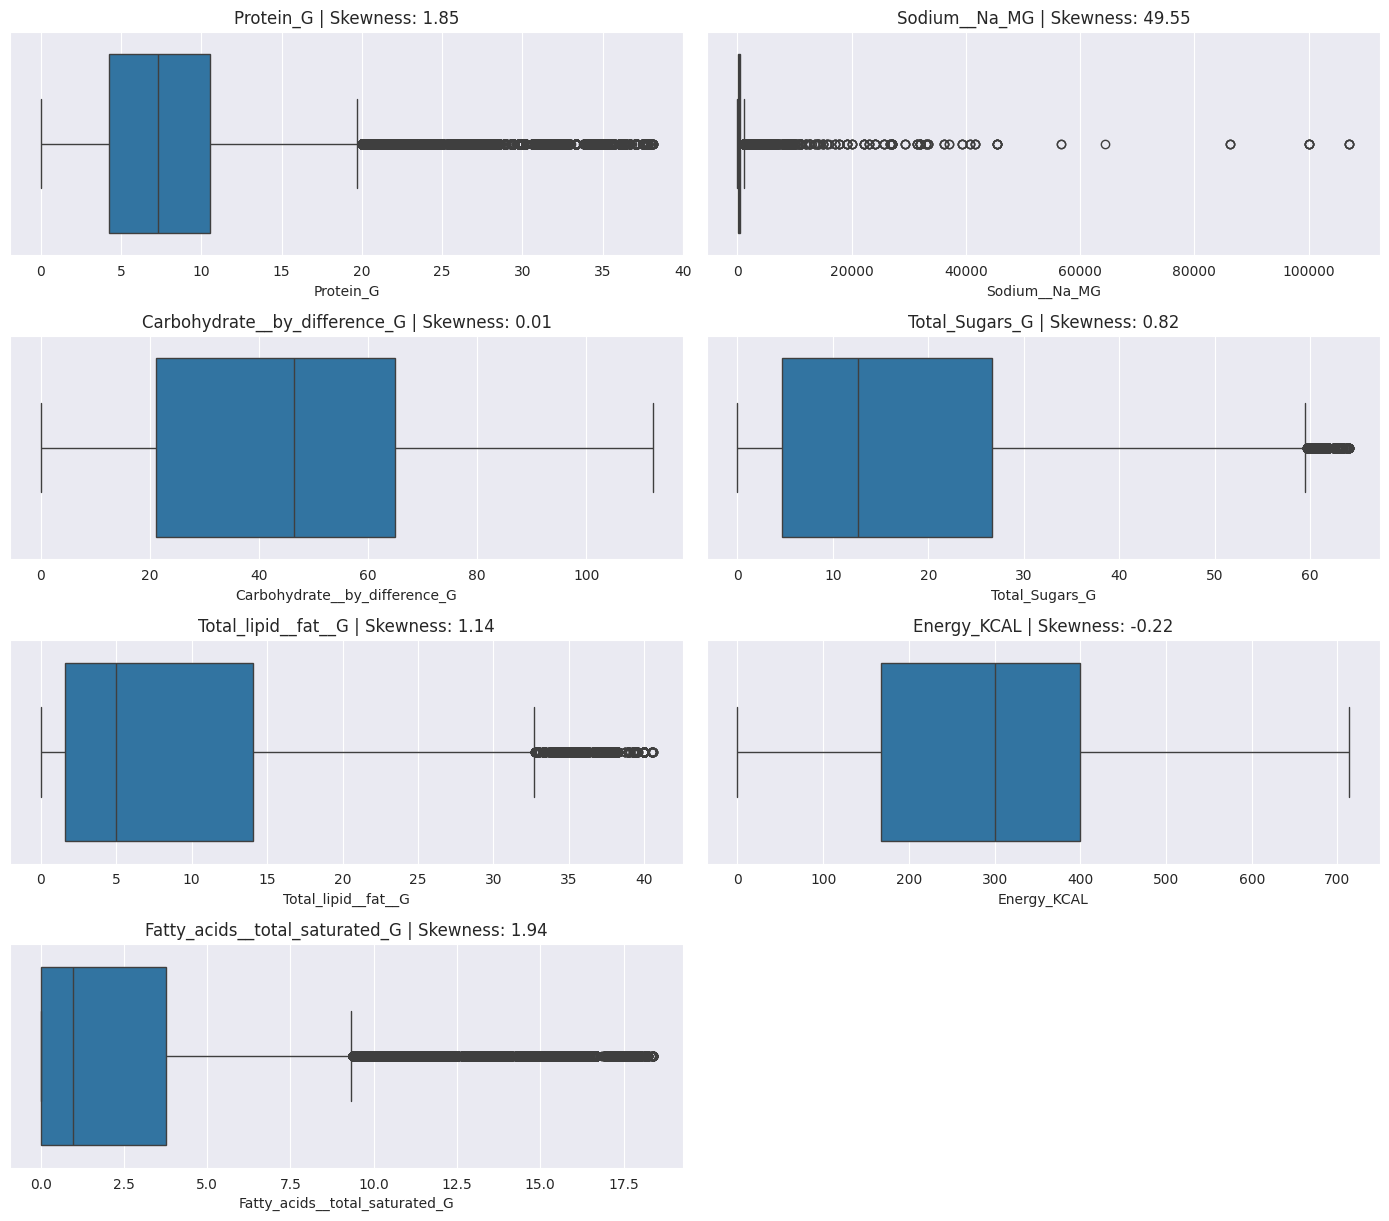

In [27]:
#Review boxplots of all columns to verify if outlier removal helped
sns.set_style("darkgrid")
numerical_columns = numerical_columns_1
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.boxplot(x=df_correlations_without_outliers[feature])
    plt.title(f"{feature} | Skewness: {round(df_correlations_without_outliers[feature].skew(), 2)}")

plt.tight_layout()
plt.show()


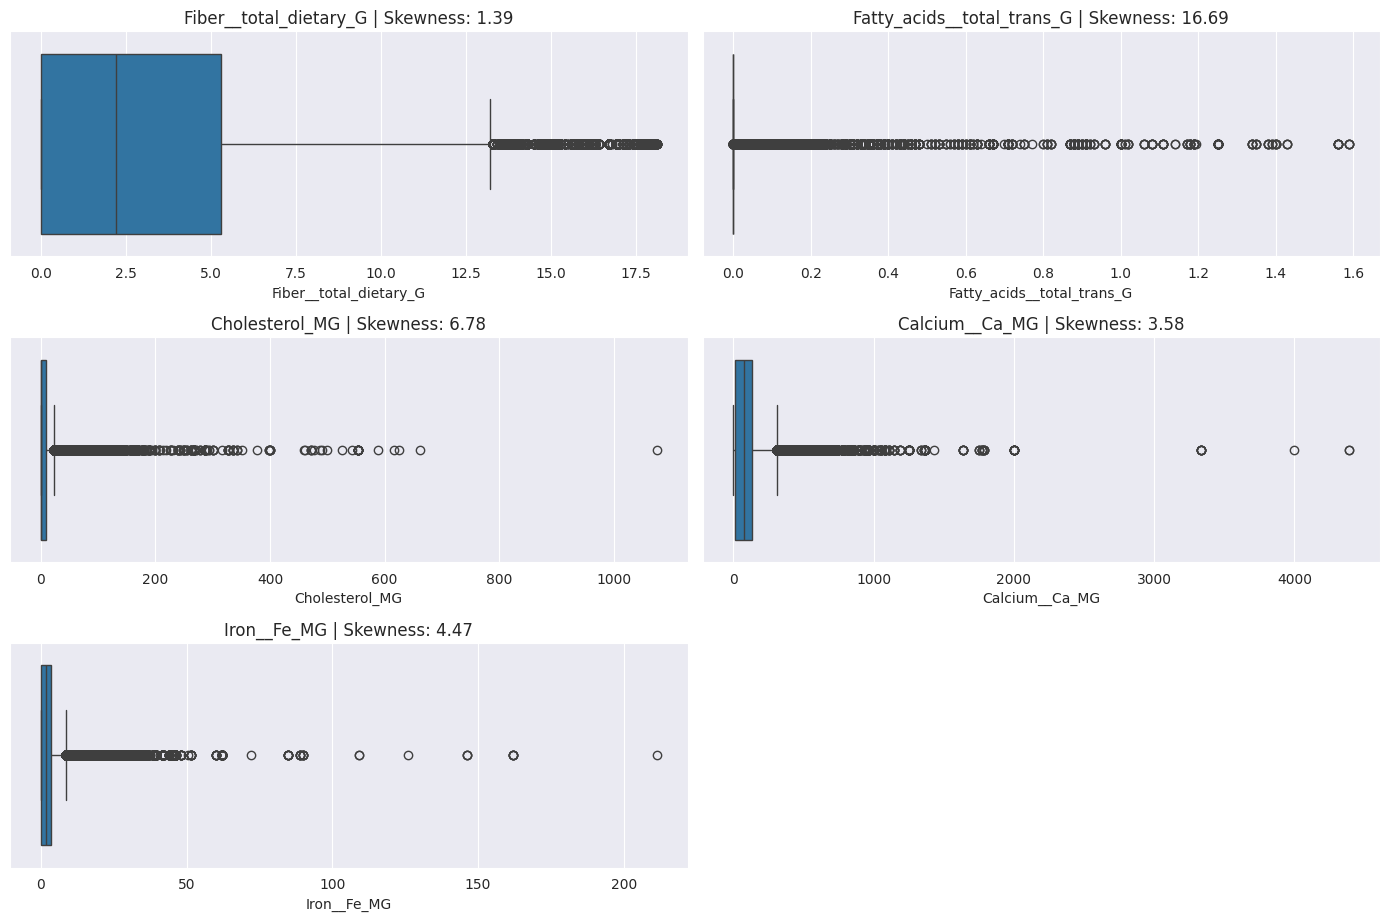

In [28]:
#Review boxplots of all columns to verify if outlier removal helped
sns.set_style("darkgrid")
numerical_columns = numerical_columns_2
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.boxplot(x=df_correlations_without_outliers[feature])
    plt.title(f"{feature} | Skewness: {round(df_correlations_without_outliers[feature].skew(), 2)}")

plt.tight_layout()
plt.show()


<i> The above box plots indicate that the z-score approach helped remove outliers to make the data more normally distributed - however the columns still have right skews. We can retain this for now.

#### d) Build Correlation Matrix

<i><u> Step 1: Check how columns correlate with the target energy column

<i> Since our first objective is to build a model that can predict the energy levels based on nutrient composition, the below snippet looks at how different columns correlate with the energy column (Energy_KCAL)<br><br>
<i> While the serving_size_unit categorical column will be dropped (since it should vary proportionally with energy for a particular category), the branded food category can be one hot encoded to see if we can see any correlation patterns between specific food categories and energy<br>

In [30]:
#To check correlation between certain features, we can also do a pair plot
df_for_correlation_updated = df_correlations_without_outliers.drop(['serving_size_unit'],axis=1)
df_for_correlation_encoded = pd.get_dummies(df_for_correlation_updated, columns=['branded_food_category'], drop_first=True, dtype=int)
df_for_correlation_updated = df_for_correlation_updated.drop(['branded_food_category'],axis=1)
correlations = df_for_correlation_encoded.corrwith(df_for_correlation_encoded['Energy_KCAL'])
print(correlations.sort_values(ascending=False))

Energy_KCAL                                                              1.000000
Carbohydrate__by_difference_G                                            0.769158
Total_lipid__fat__G                                                      0.694411
Total_Sugars_G                                                           0.486285
Fatty_acids__total_saturated_G                                           0.479822
Fiber__total_dietary_G                                                   0.478585
branded_food_category_Snack, Energy & Granola Bars                       0.393849
Protein_G                                                                0.330018
Iron__Fe_MG                                                              0.323566
branded_food_category_Cereal                                             0.227064
branded_food_category_Cookies & Biscuits                                 0.192293
branded_food_category_Chips, Pretzels & Snacks                           0.174660
branded_food_cat


<i> We can see that the carbohydrate and lipid fat columns have a high correlation with the energy column, with sugars, fatty acids and fibers have around 40-50% correlation. While serving size's negative correlation to energy is expected, tt is  interesting to note that Yogurt has a strong negative correlation with Energy. Most food categories however show very low correlation with energy - hence the branded food category column can be removed for now.

<i> The below code prints the correlation matrix for our columns of interest

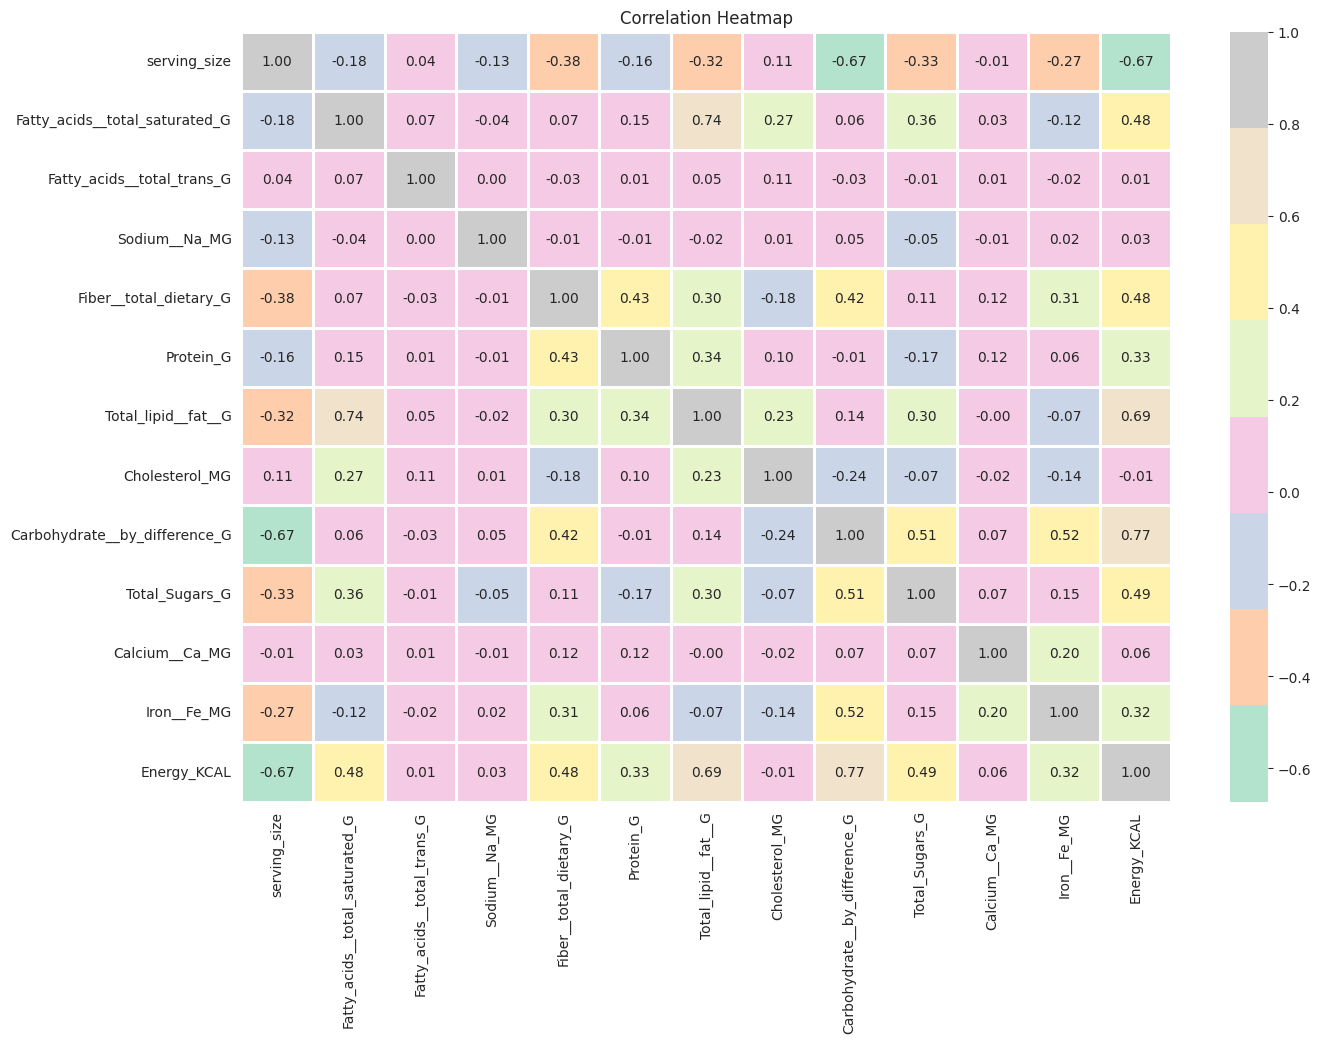

In [31]:
plt.figure(figsize=(15, 10))

sns.heatmap(df_for_correlation_updated.corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)

plt.title('Correlation Heatmap')
plt.show()

## Section 7: Building a Baseline Model [Phase 3]

#### a) Decide the Baseline Modeling Approach

<i>To build the baseline model, a linear regression approach will be used. The dataset will be split into test and training data after which the model will be trained on training data and validated using test data. The performance of the mode will then be evaulated based on the coefficient of determination score along with the MSE ( Mean Squared Error) and MAE (Mean Absolute Error) values.  

#### b) Split Data into Test and Training Data

In [35]:
#Prep step: Prepare training and test dataset

print("Check: Number of Missing Values: " + str(df_for_correlation_updated.isna().any(axis=1).sum()))

#Drop price from the feature dataset
X = df_for_correlation_updated.drop(columns = ['Energy_KCAL'])
#Create the Y dataset (price values)
Y = df_for_correlation_updated['Energy_KCAL']
#Prepare the training and test datasets - assuming 40% of the data would be used to do tests
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42, shuffle=True)
X_train.head()


Check: Number of Missing Values: 0


,serving_size,Fatty_acids__total_saturated_G,Fatty_acids__total_trans_G,Sodium__Na_MG,Fiber__total_dietary_G,Protein_G,Total_lipid__fat__G,Cholesterol_MG,Carbohydrate__by_difference_G,Total_Sugars_G,Calcium__Ca_MG,Iron__Fe_MG
165390,30.0,11.67,0.0,333.0,3.3,3.33,26.67,17.0,56.67,23.33,13.0,3.33
175721,70.0,1.43,0.0,386.0,1.4,4.29,6.43,14.0,34.29,7.14,214.0,3.86
168743,57.0,0.00,0.0,579.0,1.8,8.77,0.88,0.0,47.37,0.00,18.0,3.51
101441,104.0,0.96,0.0,413.0,1.0,10.58,5.77,34.0,23.08,0.96,19.0,1.38
132006,30.0,3.33,0.0,633.0,3.3,33.33,8.33,100.0,30.00,13.33,67.0,2.40


#### c) Conduct Linear Regression

In [36]:
#Conduct linear regression

#Create a linear regression pipeline. StandardScaler has been used here to scale data and reduce bias
linearPipe =  Pipeline([('scaler', StandardScaler()),
                     ('linear', LinearRegression())])

#Peform linear regression with the training data
linearPipe.fit(X_train,Y_train)
#See how the model predicts on training data
yPredict_Training = linearPipe.predict(X_train)
#See how the model predicts on test data
yPredict_Test = linearPipe.predict(X_test)

#Calculate regression error metrics on training data
mseTraining = mean_squared_error(yPredict_Training, Y_train)
maeTraining = mean_absolute_error(yPredict_Training, Y_train)

#Calculate regression error metrics on test data
mseTest = mean_squared_error(yPredict_Test, Y_test)
maeTest = mean_absolute_error(yPredict_Test, Y_test)

#Print regression error values
print ("******* Linear Regression Results *********")
print ("Training:")
print(f"MSE={mseTraining}, MAE={maeTraining}")
print ("Test:")
print(f"MSE={mseTest}, MAE={maeTest}")
print(f"Coefficent of Determination (Training): {linearPipe.score(X_train, Y_train)}")
print(f"Coefficent of Determination (Test): {linearPipe.score(X_test, Y_test)}")
print ("*******************************************")




******* Linear Regression Results *********
Training:
MSE=673.0872900946028, MAE=12.822485013098396
Test:
MSE=692.8700943413452, MAE=12.836121495434682
Coefficent of Determination (Training): 0.9658993907525362
Coefficent of Determination (Test): 0.9646154266872148
*******************************************


<i>The high coefficient of determination values for both training and test data indicates the linear regression model is able to do a good job of predicting trends on energy values based on individual nutrient columns. A low MAE of ~12 also indicates the model does a good job of predicting the energy values for the most part.<br><br>
<i> The MSE of 670+ and 690+ on training and test data is an interesting observation and shows that the model has the potential to throw a large error due the presence of outliers in the data. This is expected since the data we have is right skewed.<br><br>
<i> Hence there is an opportunity to evaluate other models that can handle skewed data better.